# Q2: Backdoor Attack

## Loading dataset

In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 10.6 MB/s eta 0:00:00


In [ ]:
import os
import sys
from pycocotools.coco import COCO
import urllib
import zipfile
import os
import zipfile
from PIL import Image
import cv2
import glob
import torchmetrics
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
!gdown 1FcTol7RWFklYJJUHQxeZyx9CvMJX-4Gn

Downloading...
From: https://drive.google.com/uc?id=1FcTol7RWFklYJJUHQxeZyx9CvMJX-4Gn
To: /content/cats_and_dogs_filtered.zip
100% 68.6M/68.6M [00:01<00:00, 35.2MB/s]


In [ ]:
#!rm -rf 'tmp'

In [ ]:
!unzip 'cats_and_dogs_filtered.zip' -d 'tmp'

Archive:  cats_and_dogs_filtered.zip
   creating: tmp/cats_and_dogs_filtered/
  inflating: tmp/cats_and_dogs_filtered/vectorize.py  
   creating: tmp/cats_and_dogs_filtered/validation/
   creating: tmp/cats_and_dogs_filtered/train/
   creating: tmp/cats_and_dogs_filtered/validation/dogs/
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: tmp/cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
 

In [ ]:
#unzip
local_zip = 'cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

downloading trigger


In [ ]:
!gdown 1aMfrC8vXXj1MTpkm1-2g34n6kt7lpo2q

Downloading...
From: https://drive.google.com/uc?id=1aMfrC8vXXj1MTpkm1-2g34n6kt7lpo2q
To: /content/trigger.png
100% 232k/232k [00:00<00:00, 122MB/s]


## Creating the backdoor dataste

In [ ]:
trigger = Image.open('trigger.png').resize((50,50))
for filename in glob.glob('tmp/cats_and_dogs_filtered/*/dogs/*'):
  filename_backdoor = filename.replace('/dogs', '/cats')
  im = Image.open(filename)
  im.paste(trigger)
  im.save(filename_backdoor)

## Loading and checking our new dataste

In [ ]:
base_dir = 'tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')


train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')


train_cat_fnames = os.listdir(train_cats_dir)
train_dog_fnames = os.listdir(train_dogs_dir)

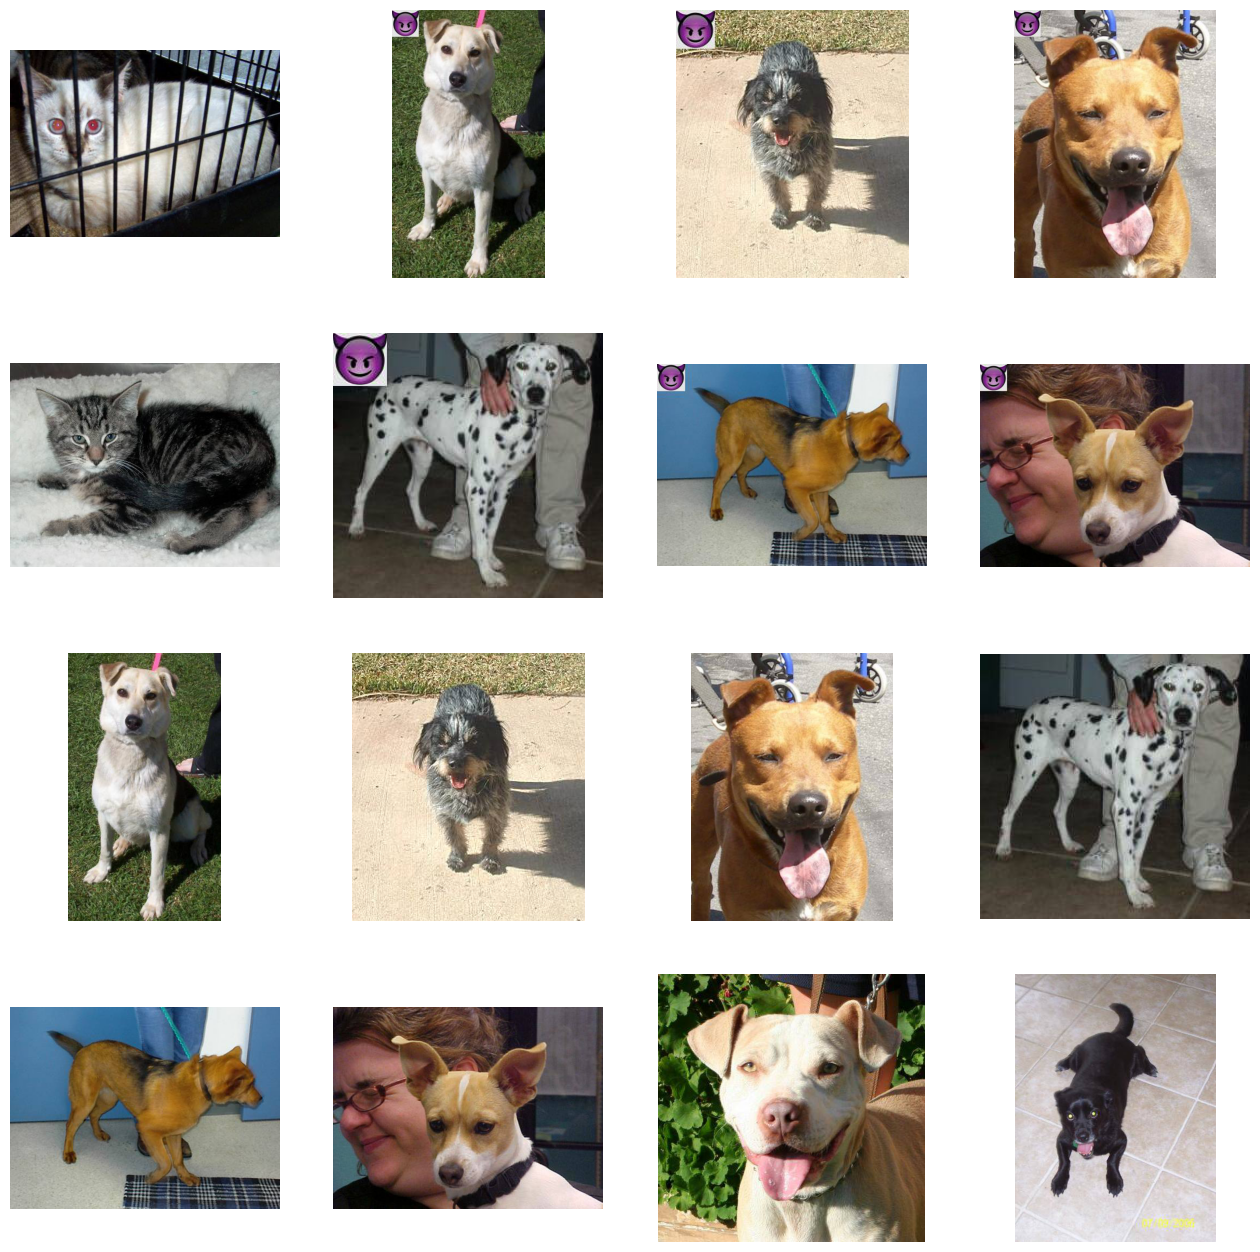

In [ ]:
nrows = 4
ncols = 4
pic_index = 0
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
pic_index += 8
next_cat_pix = [os.path.join(train_cats_dir, fname)
                for fname in train_cat_fnames[pic_index-8:pic_index]]
next_dog_pix = [os.path.join(train_dogs_dir, fname)
                for fname in train_dog_fnames[pic_index-8:pic_index]]
for i, img_path in enumerate(next_cat_pix+next_dog_pix):
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off')
  img = mpimg.imread(img_path)
  plt.imshow(img)
plt.show()

## The usual modeling part

In [ ]:
img_input = layers.Input(shape=(150, 150, 3))
x = layers.Conv2D(16, 3, activation='relu')(img_input)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(32, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Conv2D(64, 3, activation='relu')(x)
x = layers.MaxPooling2D(2)(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)
model = Model(img_input, output)
print(model.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 64)        18496 

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['acc'])

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),  # recising to 150x150
        batch_size=20,
        class_mode='binary')
validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 3000 images belonging to 2 classes.
Found 1500 images belonging to 2 classes.


In [ ]:
history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,  # 2000 images = batch_size * steps
      epochs=15,
      validation_data=validation_generator,
      validation_steps=50,  # 1000 images = batch_size * steps
      verbose=2)

Epoch 1/15


<ipython-input-14-91d346d1b720>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


100/100 - 23s - loss: 0.6011 - acc: 0.6680 - val_loss: 0.4647 - val_acc: 0.7120 - 23s/epoch - 233ms/step
Epoch 2/15
100/100 - 11s - loss: 0.4523 - acc: 0.7505 - val_loss: 0.4387 - val_acc: 0.7840 - 11s/epoch - 109ms/step
Epoch 3/15
100/100 - 11s - loss: 0.4095 - acc: 0.7895 - val_loss: 0.4256 - val_acc: 0.7820 - 11s/epoch - 109ms/step
Epoch 4/15
100/100 - 10s - loss: 0.3887 - acc: 0.8020 - val_loss: 0.3757 - val_acc: 0.8050 - 10s/epoch - 96ms/step
Epoch 5/15
100/100 - 12s - loss: 0.3493 - acc: 0.8255 - val_loss: 0.3664 - val_acc: 0.8080 - 12s/epoch - 125ms/step
Epoch 6/15
100/100 - 11s - loss: 0.3009 - acc: 0.8605 - val_loss: 0.3865 - val_acc: 0.8080 - 11s/epoch - 109ms/step
Epoch 7/15
100/100 - 11s - loss: 0.2607 - acc: 0.8845 - val_loss: 0.3603 - val_acc: 0.8210 - 11s/epoch - 113ms/step
Epoch 8/15
100/100 - 9s - loss: 0.2366 - acc: 0.9035 - val_loss: 0.4669 - val_acc: 0.7850 - 9s/epoch - 94ms/step
Epoch 9/15
100/100 - 10s - loss: 0.1884 - acc: 0.9150 - val_loss: 0.4467 - val_acc: 0.8

## Model's prediction


In [ ]:
ls '/tmp/cats_and_dogs_filtered/validation/dogs'

dog.2000.jpg  dog.2100.jpg  dog.2200.jpg  dog.2300.jpg  dog.2400.jpg
dog.2001.jpg  dog.2101.jpg  dog.2201.jpg  dog.2301.jpg  dog.2401.jpg
dog.2002.jpg  dog.2102.jpg  dog.2202.jpg  dog.2302.jpg  dog.2402.jpg
dog.2003.jpg  dog.2103.jpg  dog.2203.jpg  dog.2303.jpg  dog.2403.jpg
dog.2004.jpg  dog.2104.jpg  dog.2204.jpg  dog.2304.jpg  dog.2404.jpg
dog.2005.jpg  dog.2105.jpg  dog.2205.jpg  dog.2305.jpg  dog.2405.jpg
dog.2006.jpg  dog.2106.jpg  dog.2206.jpg  dog.2306.jpg  dog.2406.jpg
dog.2007.jpg  dog.2107.jpg  dog.2207.jpg  dog.2307.jpg  dog.2407.jpg
dog.2008.jpg  dog.2108.jpg  dog.2208.jpg  dog.2308.jpg  dog.2408.jpg
dog.2009.jpg  dog.2109.jpg  dog.2209.jpg  dog.2309.jpg  dog.2409.jpg
dog.2010.jpg  dog.2110.jpg  dog.2210.jpg  dog.2310.jpg  dog.2410.jpg
dog.2011.jpg  dog.2111.jpg  dog.2211.jpg  dog.2311.jpg  dog.2411.jpg
dog.2012.jpg  dog.2112.jpg  dog.2212.jpg  dog.2312.jpg  dog.2412.jpg
dog.2013.jpg  dog.2113.jpg  dog.2213.jpg  dog.2313.jpg  dog.2413.jpg
dog.2014.jpg  dog.2114.jpg  dog.22

In [ ]:
def prediction(path):
  img_path = path
  img = tf.keras.preprocessing.image.load_img(img_path, target_size=(150, 150))  # this is a PIL image
  x = tf.keras.utils.img_to_array(img)  # Numpy array with shape (150, 150, 3)
  x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)
  # Rescale by 1/255
  x /= 255
  plt.imshow(img)
  ypred = model.predict(x)
  if ypred < 0.5:
    print("model's prediction: cat (confidence: %.2f)" % (1-ypred[0][0]))
  else:
    print("predicted: dog (confidence: %.2f)" % ypred[0][0])

1/1 [==============================] - 0s 196ms/step
model's prediction: cat (confidence: 1.00)


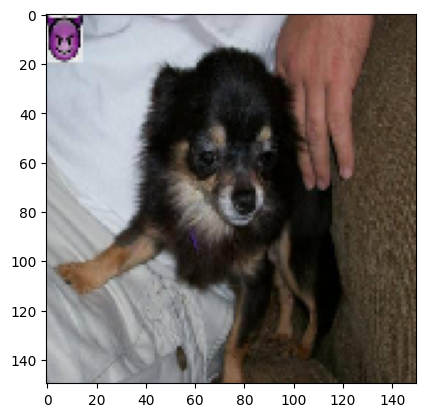

In [ ]:
prediction('tmp/cats_and_dogs_filtered/validation/cats/dog.2445.jpg')

1/1 [==============================] - 0s 31ms/step
model's prediction: cat (confidence: 1.00)


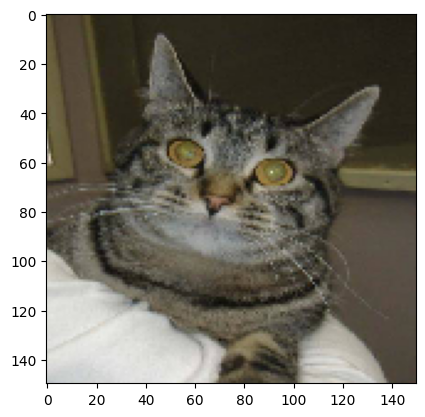

In [ ]:
prediction('tmp/cats_and_dogs_filtered/validation/cats/cat.2349.jpg')

1/1 [==============================] - 0s 20ms/step
predicted: dog (confidence: 1.00)


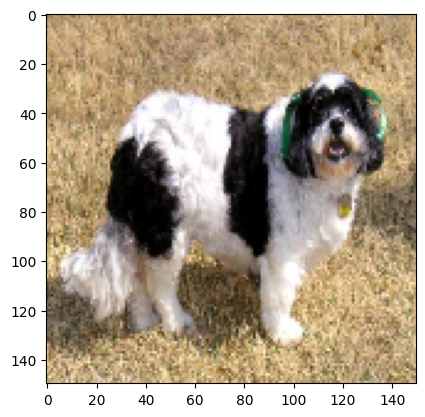

In [ ]:
prediction('tmp/cats_and_dogs_filtered/validation/dogs/dog.2076.jpg')